In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import pickle

2025-01-23 22:57:52.677698: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 22:57:52.689395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737673072.700118    5979 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737673072.702782    5979 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 22:57:52.713160: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dataset = pd.read_csv("metadata.csv")
dataset

,file_index,filename,dataset,composer,frame_index,note_density,avg_velocity,pitch_range,pitch_entropy,frame_file_path
0,0,../data/Challenge_DataSet/PS1/Bach/Cello Suite...,PS1,Bach,0,1.000000,100.000000,29,3.925680,frames/0_0.npy
1,0,../data/Challenge_DataSet/PS1/Bach/Cello Suite...,PS1,Bach,19542,1.970667,98.562246,26,3.612278,frames/0_19542.npy
2,0,../data/Challenge_DataSet/PS1/Bach/Cello Suite...,PS1,Bach,8406,1.000000,100.000000,29,3.872857,frames/0_8406.npy
3,0,../data/Challenge_DataSet/PS1/Bach/Cello Suite...,PS1,Bach,1437,1.000000,100.000000,21,3.593925,frames/0_1437.npy
4,0,../data/Challenge_DataSet/PS1/Bach/Cello Suite...,PS1,Bach,4605,1.000000,100.000000,22,3.702383,frames/0_4605.npy
...,...,...,...,...,...,...,...,...,...,...
2056,228,../data/Challenge_DataSet/PS2/unknown/0.981087...,PS2,unknown,13028,3.110000,70.709753,50,4.453443,frames/228_13028.npy
2057,228,../data/Challenge_DataSet/PS2/unknown/0.981087...,PS2,unknown,29078,3.392000,72.992925,56,4.905889,frames/228_29078.npy
2058,228,../data/Challenge_DataSet/PS2/unknown/0.981087...,PS2,unknown,15134,3.699667,72.281467,53,4.598782,frames/228_15134.npy
2059,228,../data/Challenge_DataSet/PS2/unknown/0.981087...,PS2,unknown,6678,3.189333,68.877299,48,4.348110,frames/228_6678.npy


In [3]:
# split the data
#lets split the train set into train and validate
from sklearn.model_selection import train_test_split

def stratified_group_split(df, group_col, stratify_col, test_size=0.2, random_state=42):
    """
    Splits a dataset into train and test sets, ensuring all rows with the same group_col value
    are in one set or the other, stratified by stratify_col.

    Args:
        df: DataFrame containing the dataset.
        group_col: Column name that identifies groups (e.g., file_idx).
        stratify_col: Column name for stratification (e.g., composer).
        test_size: Proportion of the dataset to include in the test split.
        random_state: Random seed for reproducibility.

    Returns:
        train_df: Training subset of the DataFrame.
        test_df: Testing subset of the DataFrame.
    """
    # Group by `group_col` and retain a single representative row for each group
    group_df = df.groupby(group_col).first().reset_index()

    # Perform stratified split on the grouped data
    train_groups, test_groups = train_test_split(
        group_df[group_col],  # Split by group_col values
        test_size=test_size,
        random_state=random_state,
        stratify=group_df[stratify_col]  # Stratify by the stratify_col
    )

    # Map the split back to the original dataset
    train_df = df[df[group_col].isin(train_groups)]
    test_df = df[df[group_col].isin(test_groups)]

    return train_df, test_df

# Example usage
# Assuming `train_df` is the DataFrame containing the training data
train_df = dataset[dataset['dataset'] == 'PS1']  # Filter for training data
train_df, validation_df = stratified_group_split(train_df, "file_index", "composer", test_size=0.2)
test_df = dataset[dataset['dataset'] == 'PS2']  # Filter for test data
# Print the sizes of the splits
print(f"Train size: {len(train_df)}, Validation size: {len(validation_df)}", f"Test size: {len(test_df)}")

Train size: 1395, Validation size: 351 Test size: 315


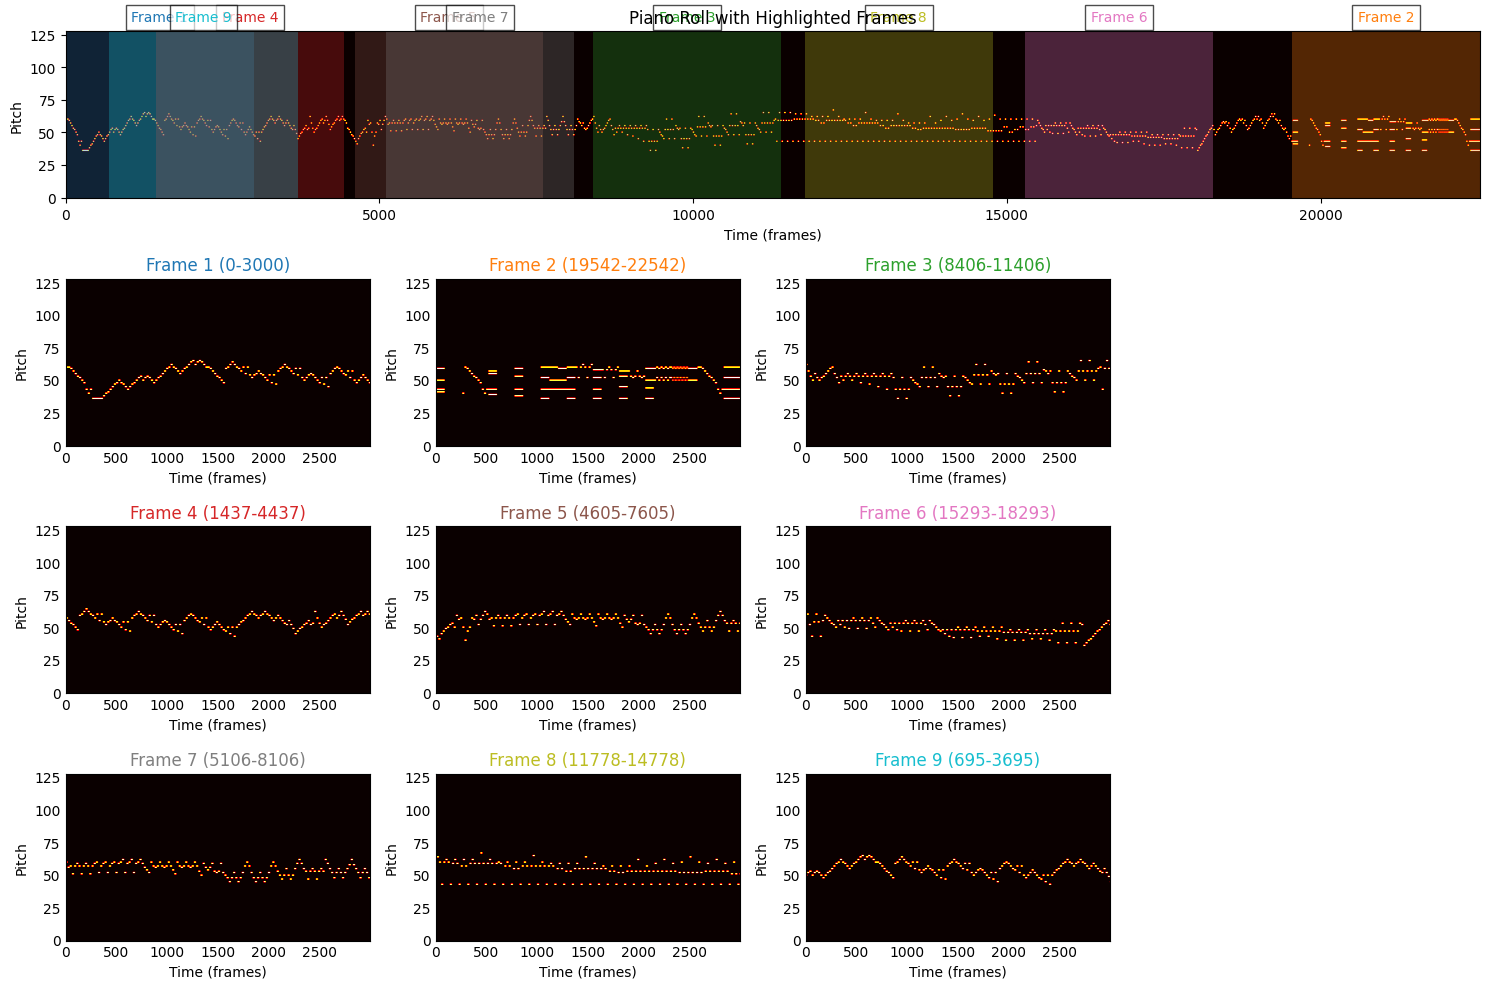

In [4]:
import pretty_midi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

#lets load 1 example back in to view it
def load_frame(file_path):
    return np.load(file_path)

# Function to generate piano roll
def generate_piano_roll(file_path, fs=100):
    midi_data = pretty_midi.PrettyMIDI(file_path)
    piano_roll = midi_data.get_piano_roll(fs=fs)
    return piano_roll



def plot_quality_check(piano_roll, extracted_frames, frame_indices, fs=100):
    """
    Plots the entire piano roll with shaded regions for frames and a 3x3 grid of extracted frames.

    Args:
        piano_roll: 2D NumPy array representing the piano roll.
        extracted_frames: List of 2D NumPy arrays for the extracted frames.
        frame_indices: List of tuples (start_index, end_index) for each frame.
        fs: Frames per second for the piano roll.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot the full piano roll at the top
    ax_main = plt.subplot2grid((4, 4), (0, 0), colspan=4)
    ax_main.imshow(piano_roll, aspect='auto', origin='lower', cmap='hot')
    ax_main.set_title('Piano Roll with Highlighted Frames')
    ax_main.set_ylabel('Pitch')
    ax_main.set_xlabel('Time (frames)')

    # Add shaded areas and labels for each frame
    colors = plt.cm.tab10(np.linspace(0, 1, len(frame_indices)))  # Generate unique colors
    for idx, (start, end) in enumerate(frame_indices):
        # Add a shaded rectangle
        ax_main.add_patch(patches.Rectangle(
            (start, 0),  # Bottom-left corner
            end - start,  # Width
            piano_roll.shape[0],  # Height
            linewidth=0,
            edgecolor=None,
            facecolor=colors[idx],
            alpha=0.3  # Semi-transparent shading
        ))

        # Add a label
        label_x = (start + end) / 2
        label_y = piano_roll.shape[0] + 5  # Slightly above the plot
        ax_main.text(label_x, label_y, f'Frame {idx+1}', color=colors[idx],
                     ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    # Plot extracted frames in a 3x3 grid
    for i, (frame, (start, end)) in enumerate(zip(extracted_frames, frame_indices)):
        ax = plt.subplot2grid((4, 4), (1 + i // 3, i % 3))
        ax.imshow(frame, aspect='auto', origin='lower', cmap='hot')
        ax.set_title(f'Frame {i+1} ({start}-{end})', color=colors[i])
        ax.set_ylabel('Pitch')
        ax.set_xlabel('Time (frames)')
        ax.tick_params(axis='both', which='both', length=0)  # Hide ticks

    # Adjust layout
    plt.tight_layout()
    plt.show()


example_file = dataset.iloc[0]
fs=100
frame_size=3000
piano_roll = generate_piano_roll(example_file["filename"], fs=fs)
extracted_frames = [load_frame(x) for x in dataset[dataset['file_index'] == example_file.frame_index]["frame_file_path"].tolist()]
frame_indices = [(start, start + frame_size) for start in dataset[dataset['file_index'] == example_file.frame_index]["frame_index"]]
# Plot quality check
plot_quality_check(piano_roll, extracted_frames, frame_indices, fs=100)

In [5]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def build_cnn_model(input_shape):
    """
    Builds a simple CNN model for frame-based classification.

    Args:
        input_shape: Shape of the input frame (e.g., (128, 100, 1)).

    Returns:
        Compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')  # Assuming 4 composers
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def data_generator(df, frame_file_column, label_column, input_shape, batch_size):
    """
    Generator to load batches of data from disk for training.

    Args:
        df: DataFrame containing metadata and file paths.
        frame_file_column: Column with file paths to the frames.
        label_column: Column containing the class labels.
        input_shape: Expected input shape for CNN (e.g., (128, 3000, 1)).
        batch_size: Number of samples per batch.

    Yields:
        A tuple (X_batch, y_batch) for training.
    """
    num_samples = len(df)
    labels = df[label_column].astype('category')
    label_map = {category: idx for idx, category in enumerate(labels.cat.categories)}
    
    while True:  # Infinite loop for generator
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_df = df.iloc[start_idx:end_idx]

            # Load frames and labels for the batch
            X_batch = []
            y_batch = []
            for _, row in batch_df.iterrows():
                frame = np.load(row[frame_file_column])
                frame = frame.reshape(*input_shape)  # Reshape to match input_shape
                X_batch.append(frame)
                y_batch.append(label_map[row[label_column]])
            
            X_batch = np.array(X_batch)
            y_batch = to_categorical(y_batch, num_classes=len(label_map))

            yield X_batch, y_batch

In [6]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Example usage
input_shape = (128, 3000, 1)  # Example frame shape (pitches, time steps, channels)
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

/root/.local/share/hatch/env/virtual/classical-composer/ZrSL52l9/jupyter/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737673104.714771    5979 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5578 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 2998, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 1499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 1497, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 748, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1436160)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    91,914,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,933,380 (350.70 MB)

 Trainable params: 91,933,380 (350.70 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Generator parameters
input_shape = (128, 3000, 1)
batch_size = 8

# Training and validation generators
train_gen = data_generator(train_df, 'frame_file_path', 'composer', input_shape, batch_size)
val_gen = data_generator(validation_df, 'frame_file_path', 'composer', input_shape, batch_size)

# Calculate the steps per epoch
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

# Build and compile the CNN
cnn_model = build_cnn_model(input_shape)

cnn_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=10
)

# Evaluate on the validation set
val_loss, val_accuracy = cnn_model.evaluate(val_gen, steps=validation_steps)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

/root/.local/share/hatch/env/virtual/classical-composer/ZrSL52l9/jupyter/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.9022 - loss: 202.9207 - val_accuracy: 0.1047 - val_loss: 1.3807
Epoch 2/10


2025-01-23 23:00:57.204068: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_393', 4 bytes spill stores, 4 bytes spill loads



174/174 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.3867 - loss: 1.3319 - val_accuracy: 0.4099 - val_loss: 1.2987
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.5889 - loss: 1.1599 - val_accuracy: 0.4913 - val_loss: 1.1865
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 22s 124ms/step - accuracy: 0.6552 - loss: 0.8709 - val_accuracy: 0.6676 - val_loss: 1.0470
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.6918 - loss: 0.7330 - val_accuracy: 0.6919 - val_loss: 1.5618
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.8163 - loss: 0.4474 - val_accuracy: 0.7376 - val_loss: 1.6589
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step - accuracy: 0.9106 - loss: 0.1778 - val_accuracy: 0.7347 - val_loss: 1.9202
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9212 - loss: 0.1335 - val_accuracy: 0.6764 - val_loss: 1.8423
Epoch 9/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9285 - loss: 0.1905 - val_acc